Best ccp_alpha: 0.00044968821564566296
Accuracy: 0.7585470085470085

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.93      0.87       448
           1       0.67      0.75      0.71       349
           2       0.64      0.14      0.23       112
           3       1.00      0.59      0.74        27

    accuracy                           0.76       936
   macro avg       0.78      0.60      0.64       936
weighted avg       0.75      0.76      0.73       936



C:\Users\Mohammed El-Kholany\AppData\Local\Temp\ipykernel_7060\3444508070.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'], palette='viridis')


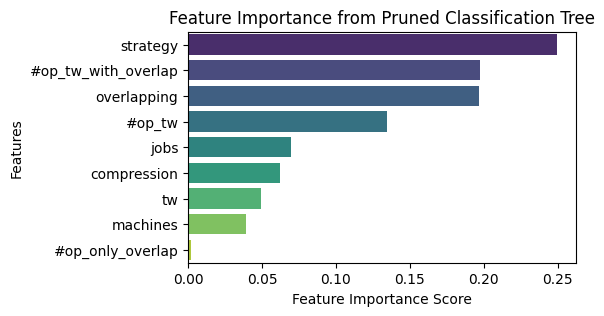

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Read the CSV and preprocess the dataset
df = pd.read_csv("scheduling_results_4_classes_cleaned_18-02-2025.csv", header=None)
df = df[0].str.split(';', expand=True)
df.columns = ['instance', 'jobs', 'machines', 'strategy', 'tw', 'compression', 
              'overlapping', '#op_tw_with_overlap', '#op_tw', '#op_only_overlap', 'makespan', 'gap_to_opt_percent', 'opt_class']

# Convert numeric columns
df[['jobs', 'machines', 'tw', '#op_tw_with_overlap', '#op_tw', '#op_only_overlap', 'makespan', 'gap_to_opt_percent']] = \
    df[['jobs', 'machines', 'tw', '#op_tw_with_overlap', '#op_tw', '#op_only_overlap', 'makespan', 'gap_to_opt_percent']].apply(pd.to_numeric, errors='coerce')

# Encode categorical columns
label_encoder = LabelEncoder()
categorical_cols = ['strategy', 'compression', 'overlapping', 'opt_class']
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

# Define features and target variable
x = df[['jobs', 'machines', 'strategy', 'tw', 'compression', 'overlapping', '#op_tw_with_overlap', '#op_tw', '#op_only_overlap']]
y = df['opt_class']

# Split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Train an initial decision tree to determine optimal pruning parameter
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(x_train, y_train)

# Get cost complexity pruning path
path = decision_tree.cost_complexity_pruning_path(x_train, y_train)
alphas = path.ccp_alphas

# Train and evaluate trees with different pruning levels
pruned_trees = []
scores = []
for alpha in alphas:
    pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    cv_score = cross_val_score(pruned_tree, x_train, y_train, cv=10, scoring='accuracy').mean()
    pruned_trees.append(pruned_tree)
    scores.append(cv_score)

# Choose the best alpha (one with the highest cross-validation accuracy)
best_alpha = alphas[np.argmax(scores)]
print(f"Best ccp_alpha: {best_alpha}")

# Train final pruned tree
pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
pruned_tree.fit(x_train, y_train)

# Predict on the test set
y_pred = pruned_tree.predict(x_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Feature importance analysis
feature_importances = pruned_tree.feature_importances_
importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importances
plt.figure(figsize=(5, 3))
sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'], palette='viridis')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance from Pruned Classification Tree")
plt.show()
